In [1]:
# install packages if imports dont work

import numpy as np
import pandas as pd
import seaborn as sns
import os
from numpy.polynomial import polynomial as P
from matplotlib import pyplot as plt

In [2]:
# Setting working directory
print(f'Before={os.getcwd()}') 

path = 'C:\\Users\\1412r\\sciebo\\GuiltAndResponsibility'
os.chdir(path) # Set wd to \sciebo\GuiltAndResponsibility
print(f'After={os.getcwd()}')

Before=C:\Users\1412r\sciebo\GuiltAndResponsibility\Codes
After=C:\Users\1412r\sciebo\GuiltAndResponsibility


In [3]:
# Get csv data

#print(os.getcwd())
path = 'Data/PD_Data1/rand.csv'
df = pd.read_csv(path, header=0, delimiter=';')

#df.head()

In [4]:
# Housekeeping

drop_cols = ['time_php', 'time_js', 'treatment', 'context', 'prev', 'prev_player',  'prev_opp', 'session']
df.drop(columns=drop_cols, inplace=True)

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Add column for the partner's payoff

df['payoff_opponent'] = df['payoff'] # Payoffs are same when both take the same action
df['payoff_opponent'].loc[(df['action_player']=='C') & (df['action_opponent']=='D')] = 4
df['payoff_opponent'].loc[(df['action_player']=='D') & (df['action_opponent']=='C')] = 0

In [7]:
# Some model parameters

number_of_participants = len(df['player'].unique())

In [8]:
# PLayer wise frequency of action C and outcomes (C, C) and (D, D)

freq_table = pd.DataFrame(index=df['player'].unique(), columns=['C_freq', 'CC_freq', 'DD_freq'])

for i in df['player'].unique():
    freq_table.loc[i, 'C_freq']  = sum((df['action_player']=='C')&(df['player']==i))/sum(df['player']==i)
    freq_table.loc[i, 'CC_freq'] = sum((df['action_opponent']=='C')&(df['action_player']=='C')&(df['player']==i))/sum(df['player']==i)
    freq_table.loc[i, 'DD_freq'] = sum((df['action_opponent']=='D')&(df['action_player']=='D')&(df['player']==i))/sum(df['player']==i)

# Adding D_freq column for future convenience 
freq_table['D_freq'] = 1-freq_table['C_freq']

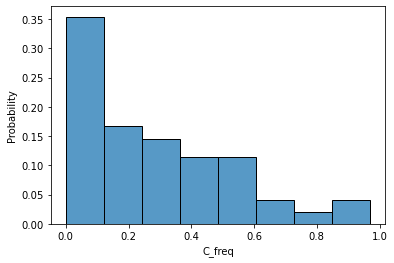

In [9]:
# Histogram of frequency of players playing C
ax = sns.histplot(x=freq_table['C_freq'], stat='probability')

<AxesSubplot:xlabel='CC_freq', ylabel='Probability'>

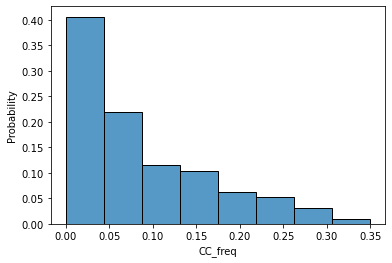

In [10]:
# Histogram of frequency of the outcome (C, C)
sns.histplot(x=freq_table['CC_freq'], stat='probability')

<AxesSubplot:xlabel='DD_freq', ylabel='Probability'>

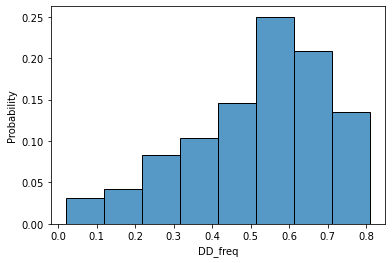

In [11]:
# Histogram of frequency of the outcome (D, D)
sns.histplot(x=freq_table['DD_freq'], stat='probability')

In [12]:
# Player wise distribution of action C (this time with )

def make_freqplot(i):
    stop = sum(df['player']==i)+1
    temp = pd.get_dummies(df[df['player']==i]['action_player'])
    temp['CumD'] = (temp['D'].cumsum())/range(1, stop)
    
    sns.lineplot(x=temp.index, y=temp['CumD']).set(ylabel='Probability of choosing D', xlabel=i)

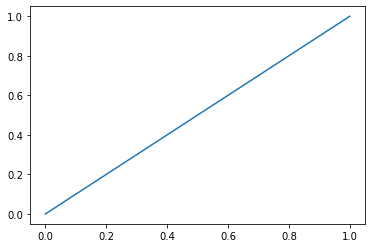

In [13]:
# Dummy graph to set the axis in the subsequent graphs
ax=sns.lineplot(x=np.linspace(0, 1, 100, endpoint=True), y=np.linspace(0, 1, 100, endpoint=True))

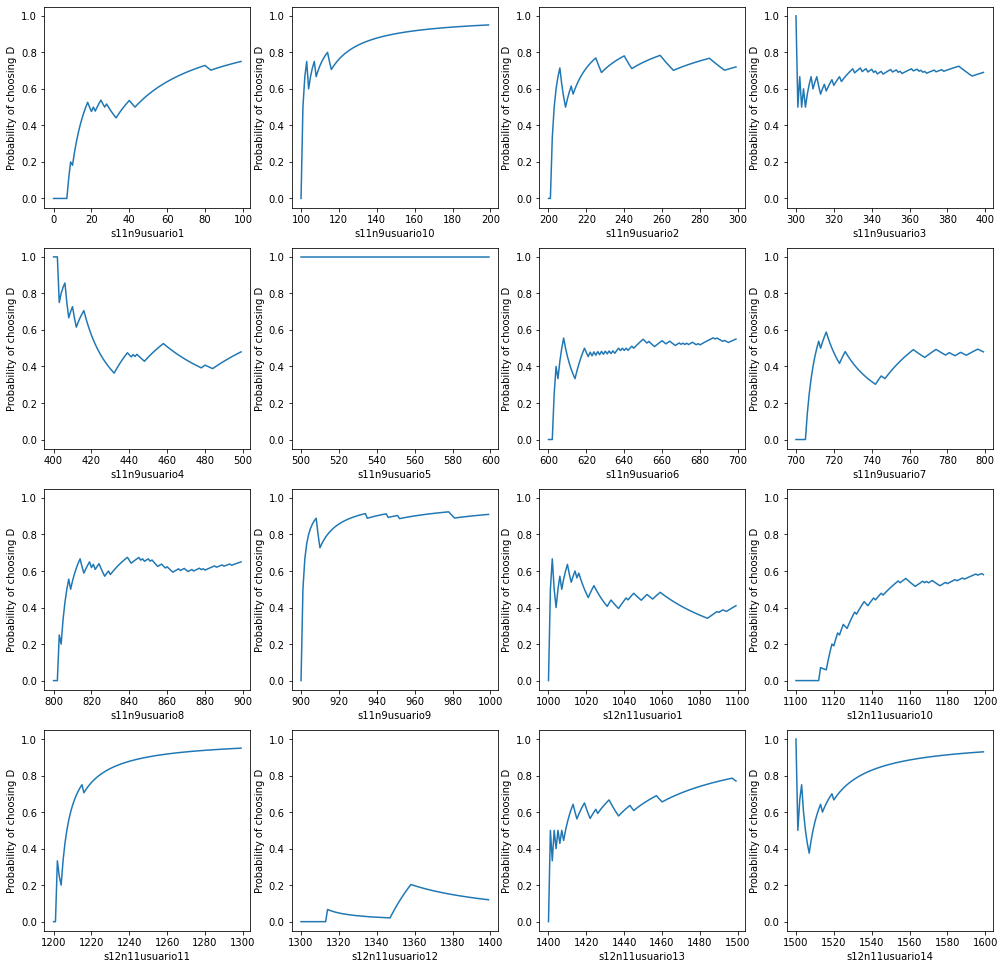

In [14]:
count = 1
no_of_cols = 4
no_of_rows = 4
players = np.array_split((df['player'].unique()), 6)

# Graph
plt.figure(figsize=(17, 17))
plt.title('Player wise probabilty of playing D wrt number of rounds for players 1-16')

for i in players[0]:
    plt.subplot(no_of_rows, no_of_cols, count, sharey=ax)
    make_freqplot(i)
    count+=1

plt.show()

Do the rest of the graphs later (too much time consuming)

### Chi square test to observe dependence of type of player and their choice

In [15]:
from scipy.stats import chi2_contingency

In [16]:
# Function to make contigency table for Chi-square test taking 'f' as the threshold

def chi2test(f):
    exp1 = freq_table[freq_table['D_freq']>f].sum()
    exp2 = freq_table[freq_table['D_freq']<=f].sum()

    cont_table = pd.DataFrame(index=['C', 'D'], columns=['Above f', 'Below f'], data=[[exp1[0], exp2[0]], [exp1[3], exp2[3]]])
    
    # Chi-square test
    chi2, p, dof, expected = chi2_contingency(cont_table)

    # interpret p-value
    alpha = 0.05
    print("p value is " + str(p))
    if p <= alpha:
        print('Reject H0: Variables are dependent')
    else:
        print('H0 holds true: Variables are independent')

In [17]:
print('Taking threshold as 0.05')
chi2test(0.05)

Taking threshold as 0.05
p value is 0.6807646253377435
H0 holds true: Variables are independent


In [18]:
print('Taking threshold as 0.15')
chi2test(0.15)

Taking threshold as 0.15
p value is 0.07006096136958699
H0 holds true: Variables are independent


In [19]:
print('Taking threshold as 0.2')
chi2test(0.2)

Taking threshold as 0.2
p value is 0.011842067966069696
Reject H0: Variables are dependent


In [20]:
print('Taking threshold as 0.25')
chi2test(0.25)

Taking threshold as 0.25
p value is 0.0054083905429788215
Reject H0: Variables are dependent


In [21]:
print('Taking threshold as 0.5')
chi2test(0.5)

Taking threshold as 0.5
p value is 4.844017581926365e-05
Reject H0: Variables are dependent


In [22]:
print('Taking threshold as 0.75')
chi2test(0.75)

Taking threshold as 0.75
p value is 3.978567237971909e-05
Reject H0: Variables are dependent


# CR Utility

In [23]:
# Grid parameters

steps = 11 ##### Input number of steps here
N = df.shape[0]

alpha_range = np.linspace(0, 1, steps, endpoint=True)
beta_range  = np.linspace(0, 1, steps, endpoint=True)
col = []

for alpha in alpha_range: 
    for beta in beta_range: 
        name = str(alpha), str(beta)
        col  = col + [name]

In [24]:
# Create empty dataframes
action1 = pd.DataFrame(index=df.index, columns=col)    # utility matrix
error1  = pd.DataFrame(index=df.index, columns=col)    # error matrix

In [25]:
# Action Grid: C for beta > 0.25 and D for beta < 0.25 except when alpha + beta > 1 (no equality in 11 steps' case)

for i in range(len(col)):
    beta = float(col[i][1]) # convert beta (from column name) from string to float
    if beta > 0.25:
        action1.iloc[:, i] = 'C'
    if beta < 0.25:
        alpha = float(col[i][0])
        if (alpha+beta > 1): # if alpha > 0.75:
            action1.iloc[:, i] = 'C'
        if (alpha+beta < 1): # if alpha < 0.75:
            action1.iloc[:, i] = 'D'
        
#action1.head()

In [26]:
# Calculating error matrix

for x in col:
    error1[x] = action1[x]==df['action_player']
    
error1 = 1 - error1 # Converting to ones and zeros from trues and falses
error1['player'] = df['player'] # Adding player column for easier future calculations

#error1.head()

In [27]:
# Calculate average error for each participant

data = []

for i in df['player'].unique():
    sum_of_error     = (error1[error1['player']==i].iloc[:,:-1]).sum() # summing over error rows where player == i and taking every column except the last (which is the name column) using iloc
    number_of_trials = (df['player']==i).sum()
    data             = data + [sum_of_error/number_of_trials]
    
avg_error1 = pd.DataFrame(data=data)

#avg_error1.head()

In [28]:
# Minimise error

min_error1 = avg_error1.idxmin(axis=1) # gives the first pair where minimum error occurs
#min_error1

In [29]:
# Find indices with minimum error

s = avg_error1.eq(avg_error1.min(axis=1), axis=0) # dataframe of boolean wherever min occurs
min_error_indices = s.agg(lambda s: s.index[s].values, axis=1) # row wise aggregating indices of columns where true occurs
#min_error_indices

In [30]:
# Creating a dataframe of alphas and betas which give minimum error, for every player

min_param = pd.DataFrame(min_error_indices[0].tolist(), columns=['alpha', 'beta'])
min_param['player'] = 0

for i in min_error_indices.index:
    if i == min_error_indices.index.stop-1:
        break
    temp_df = pd.DataFrame(min_error_indices[i+1].tolist(), columns=['alpha', 'beta'])
    temp_df['player'] = i+1
    min_param = pd.concat([min_param, temp_df])
    
min_param.index = range(len(min_param))

#min_param

In [31]:
# Find player wise average alpha and beta

min_param['alpha'] = min_param['alpha'].astype(float) # conevrting type from string to float
min_param['beta']  = min_param['beta'].astype(float)   # conevrting type from string to float

final = min_param.groupby(by=['player']).mean() # grouping by mean wrt player

### Heatmaps

In [32]:
# Function to make heatmaps

def make_heatmap(player_no):
    temp_player = pd.DataFrame(index=alpha_range, columns=beta_range) # Creating empty dataset
    
    # Creating table to make heatmap
    for i in range(len(col)): 
        alpha = float(col[i][0])
        beta  = float(col[i][1])
        temp_player.loc[alpha, beta] = avg_error1[col[i]][player_no]
    temp_player = temp_player.astype(float)
    
    # Creating heatmap
    ticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    sns.set(rc = {'figure.figsize':(30,30)})
    sns.heatmap(data=temp_player, cmap="Blues", 
                      vmin=0, vmax=1, xticklabels=ticks, yticklabels=ticks,
                      #cbar=False, annot=True, linewidths=.5
                     ).set(ylabel='Alpha', xlabel='Beta', title=(error1['player'].unique())[player_no])

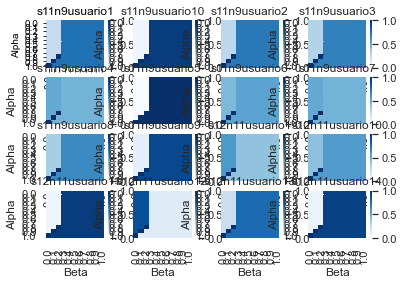

In [33]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i)
    
plt.show()

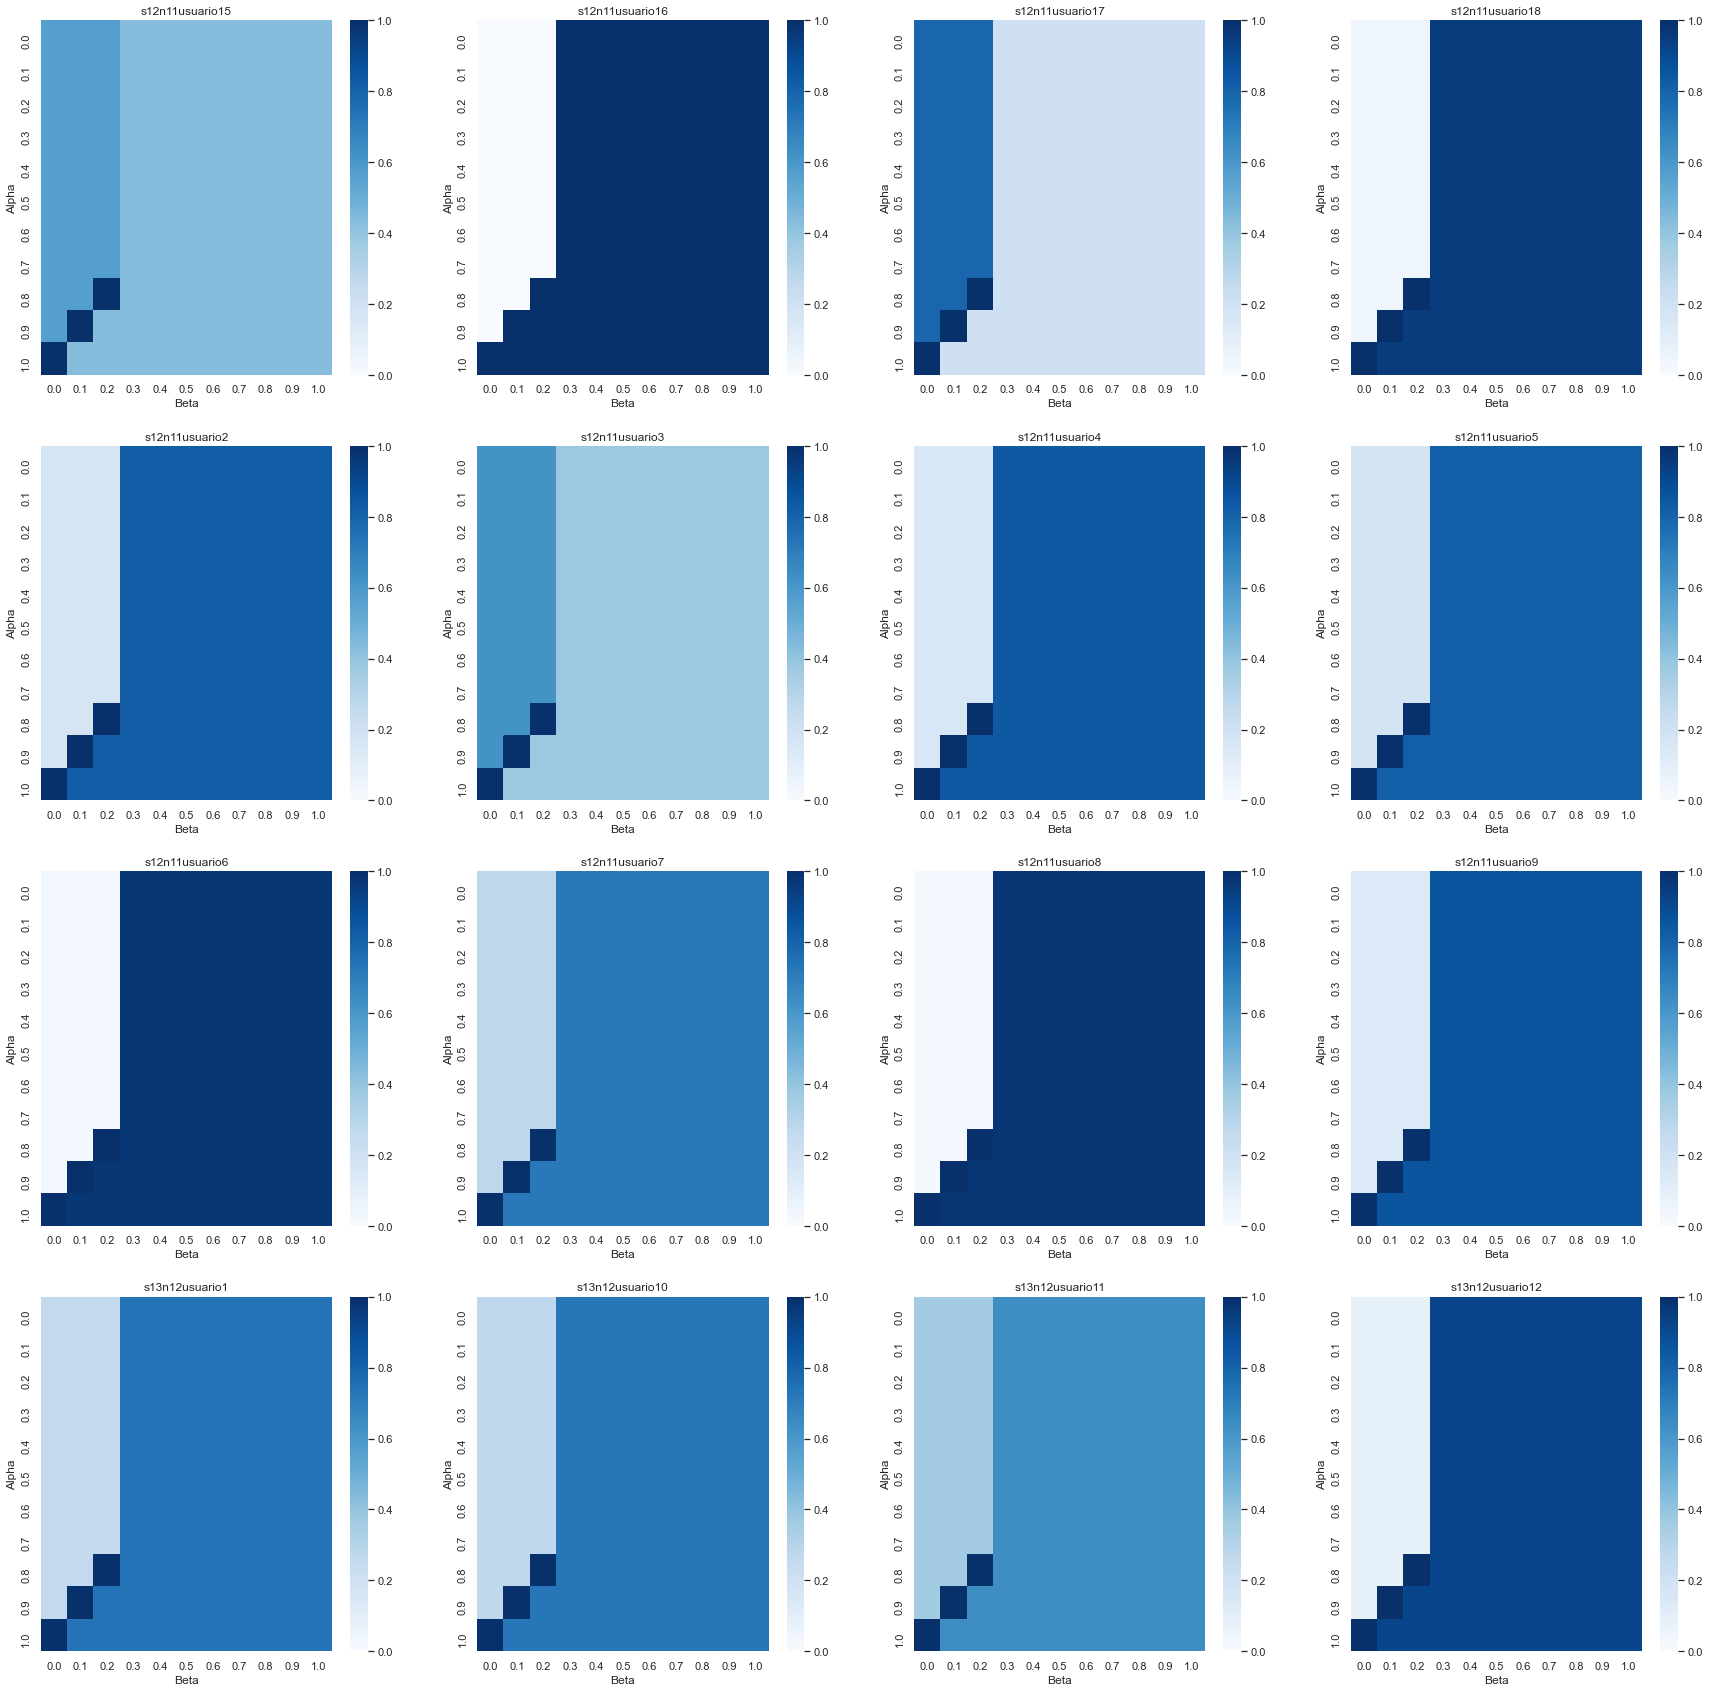

In [34]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i+16)
    
plt.show()

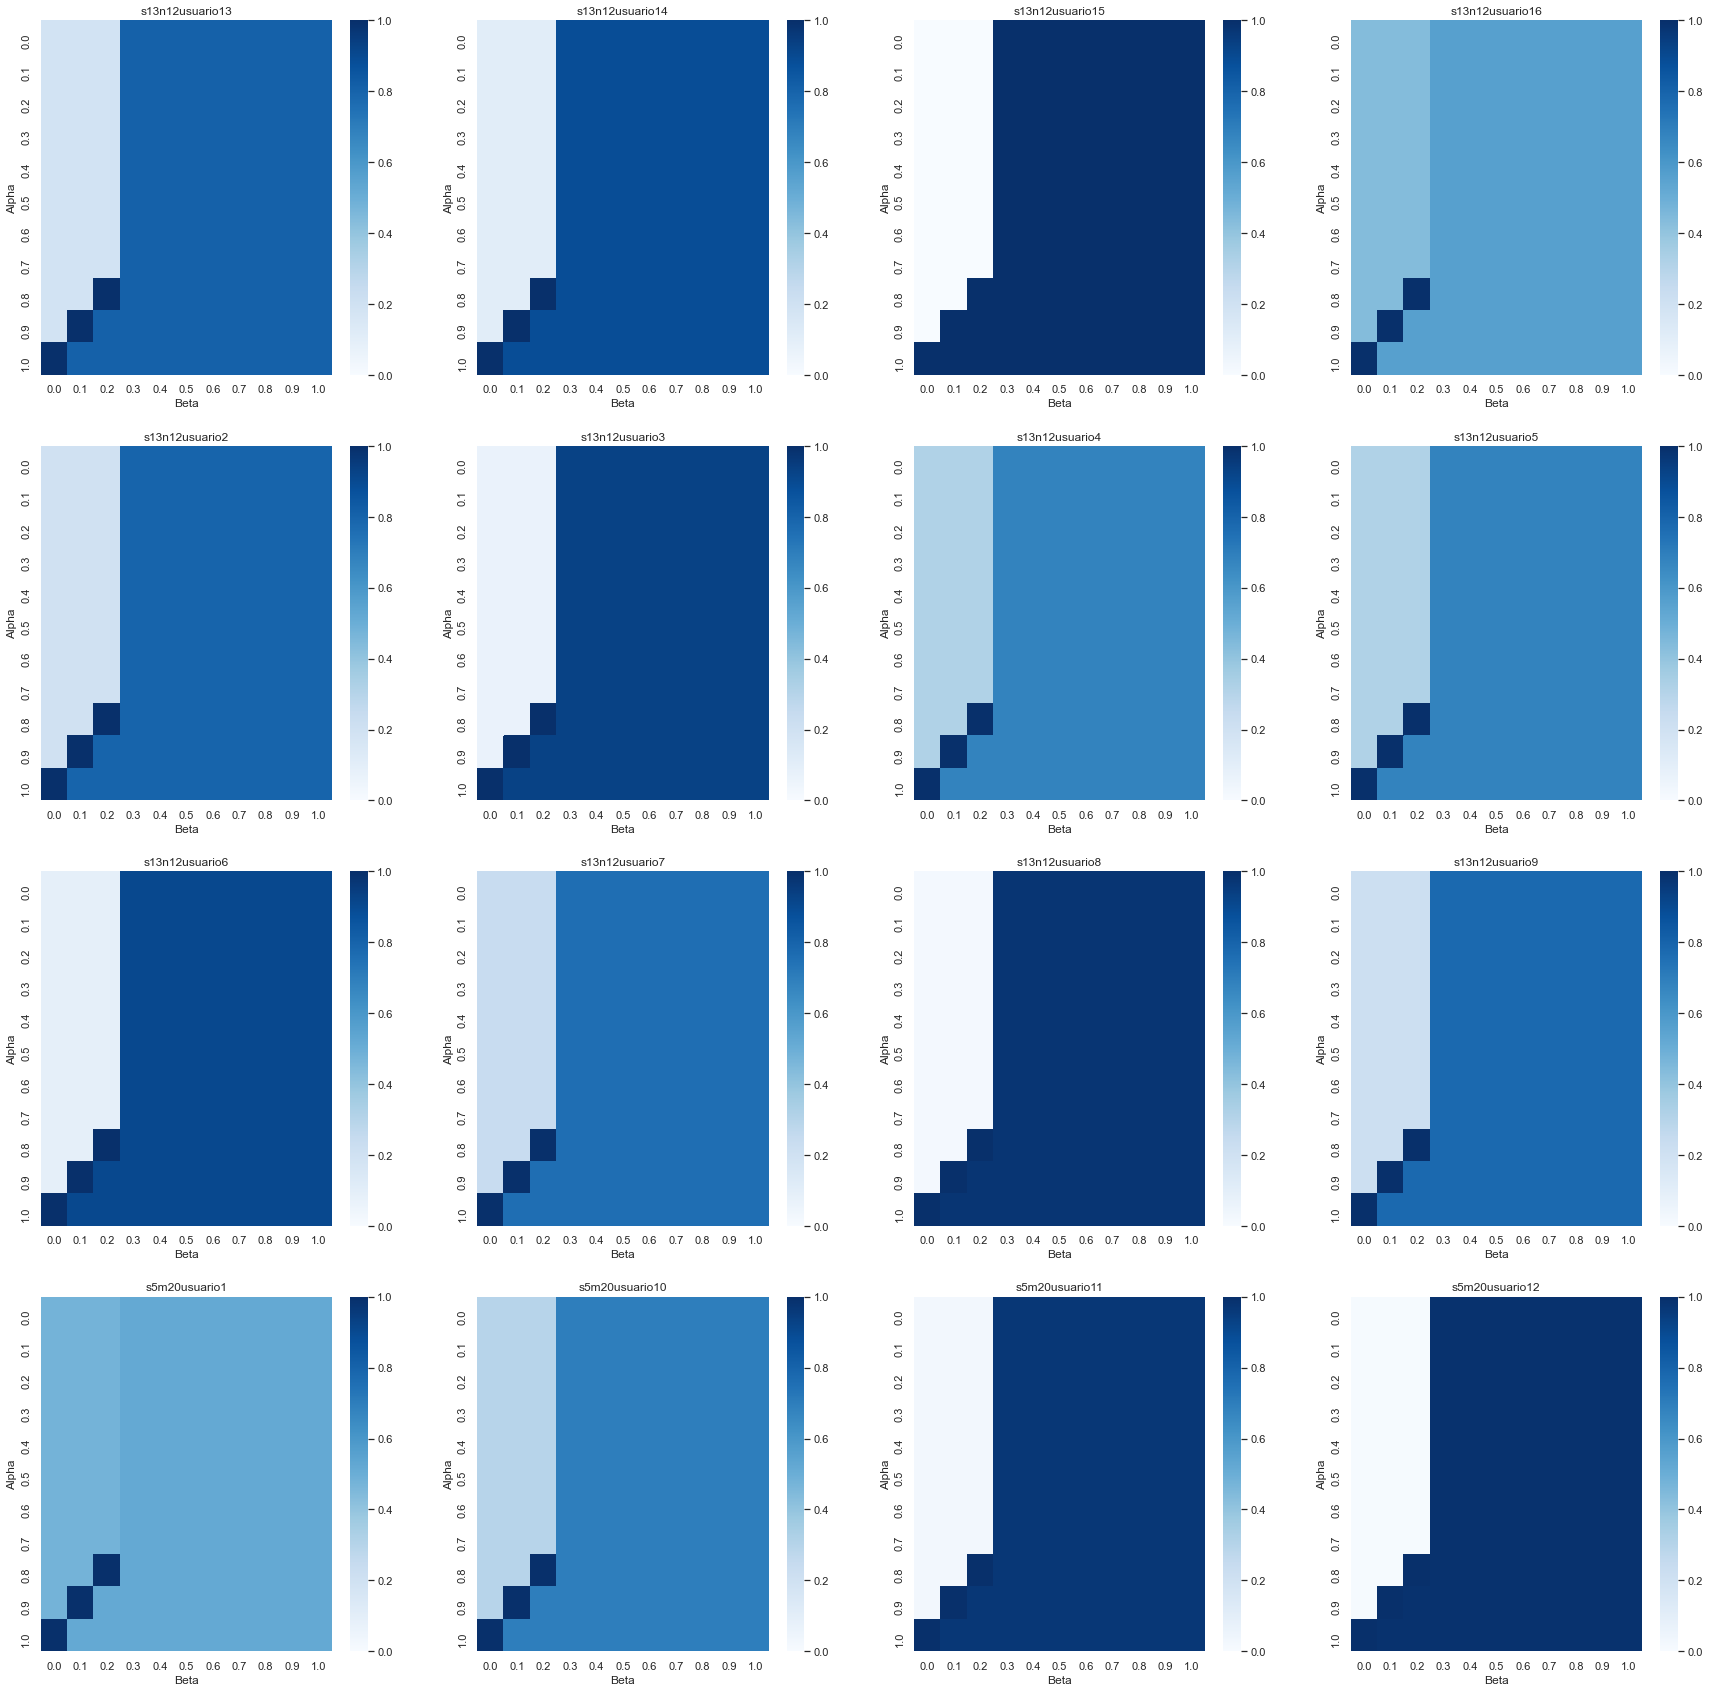

In [35]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i+32)
    
plt.show()

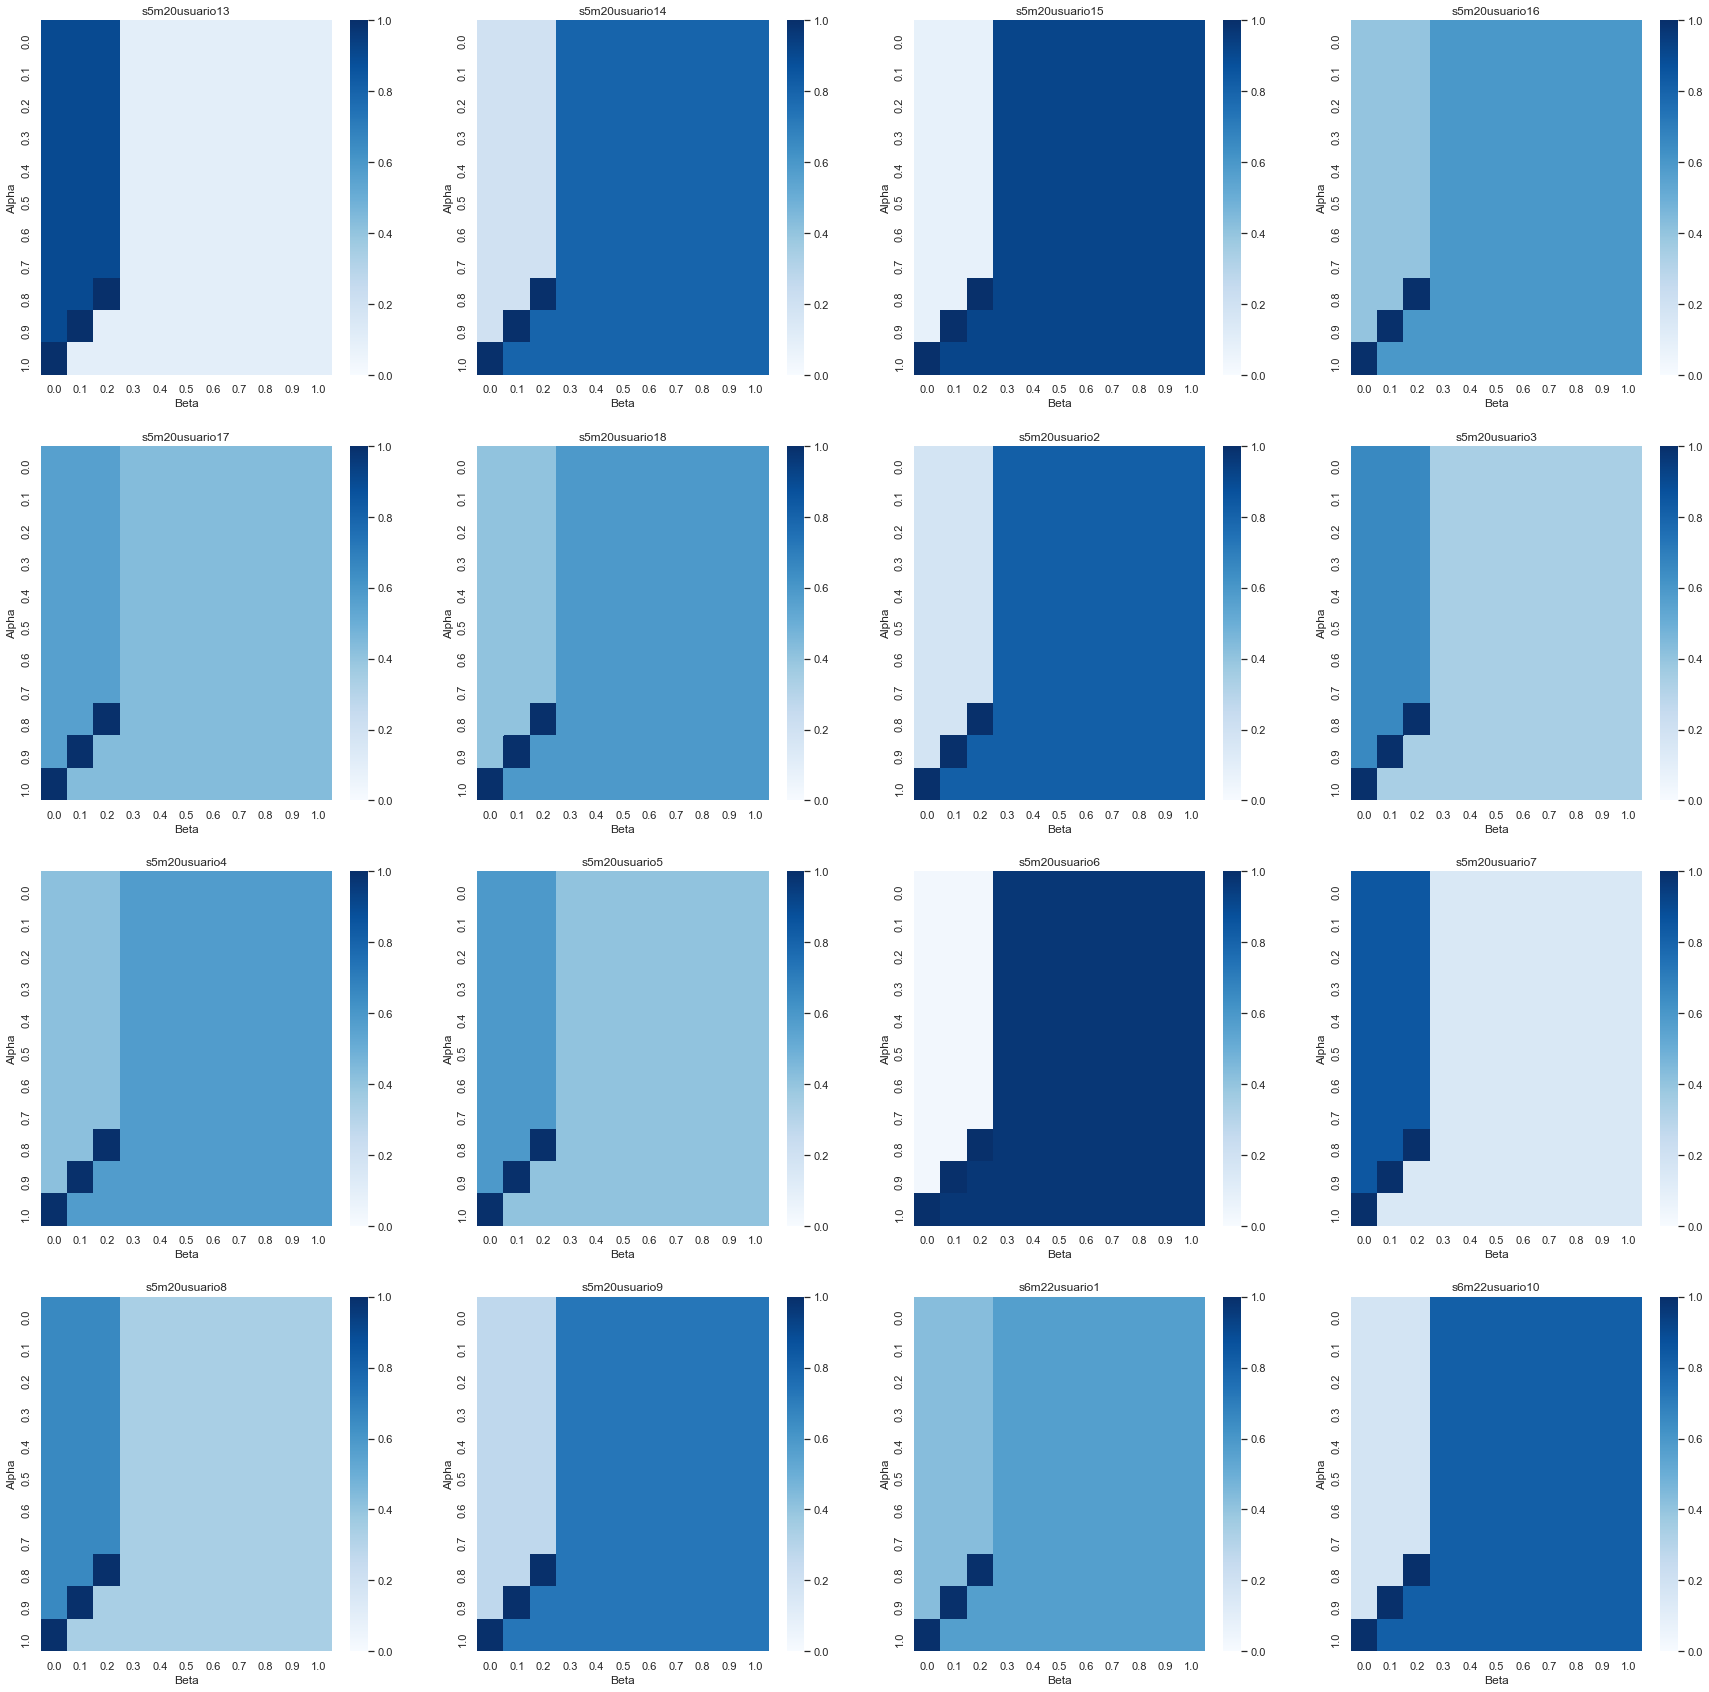

In [36]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i+48)
    
plt.show()

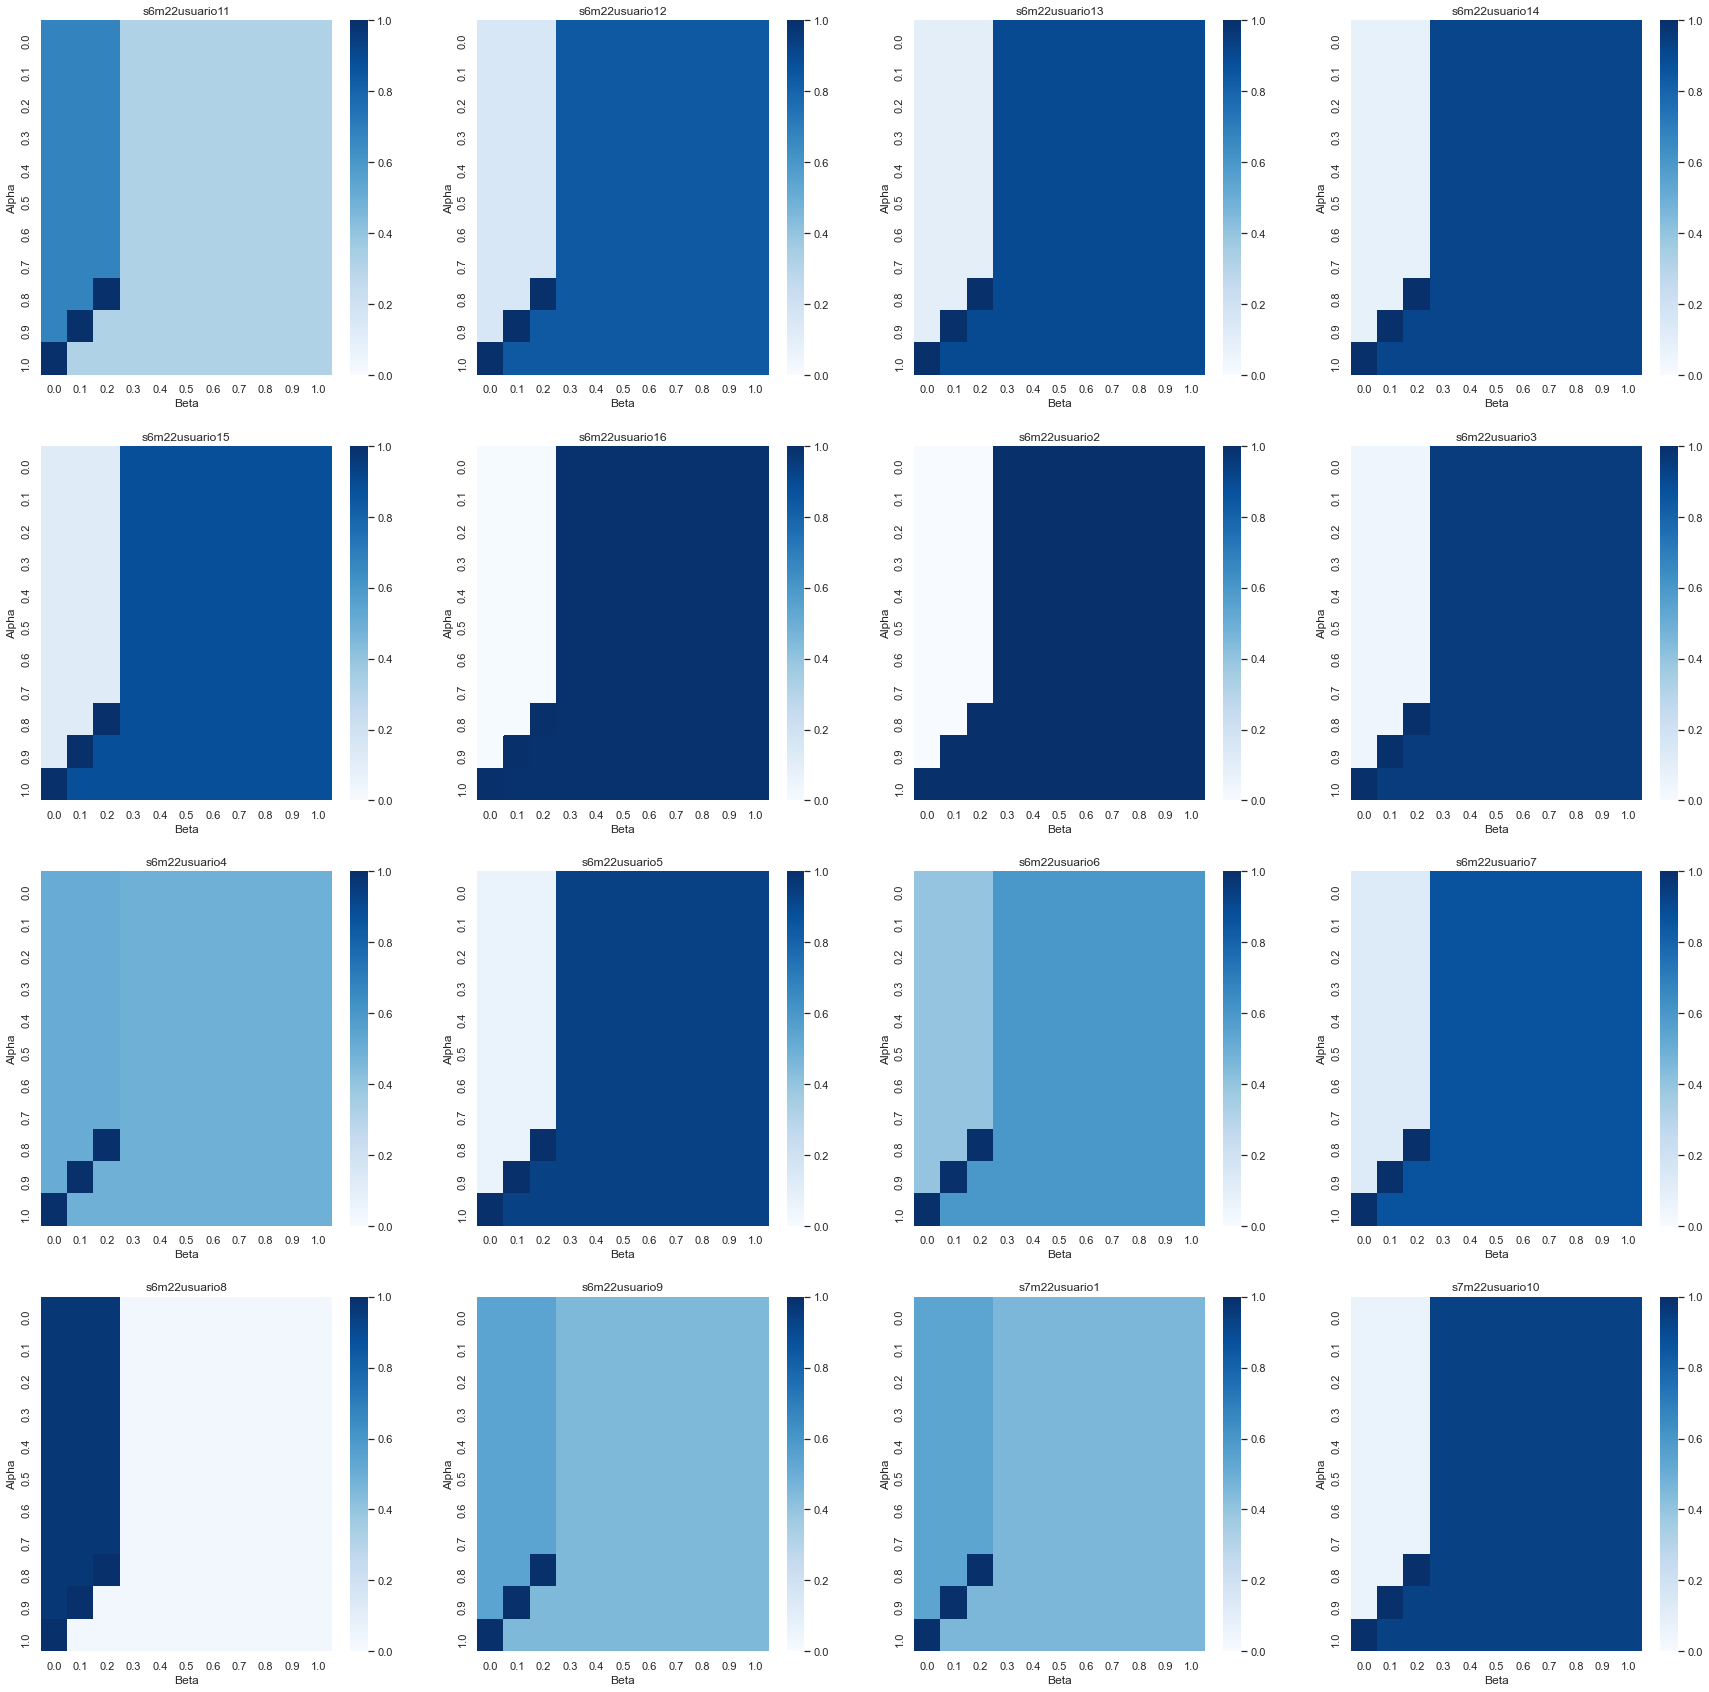

In [37]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i+64)
    
plt.show()

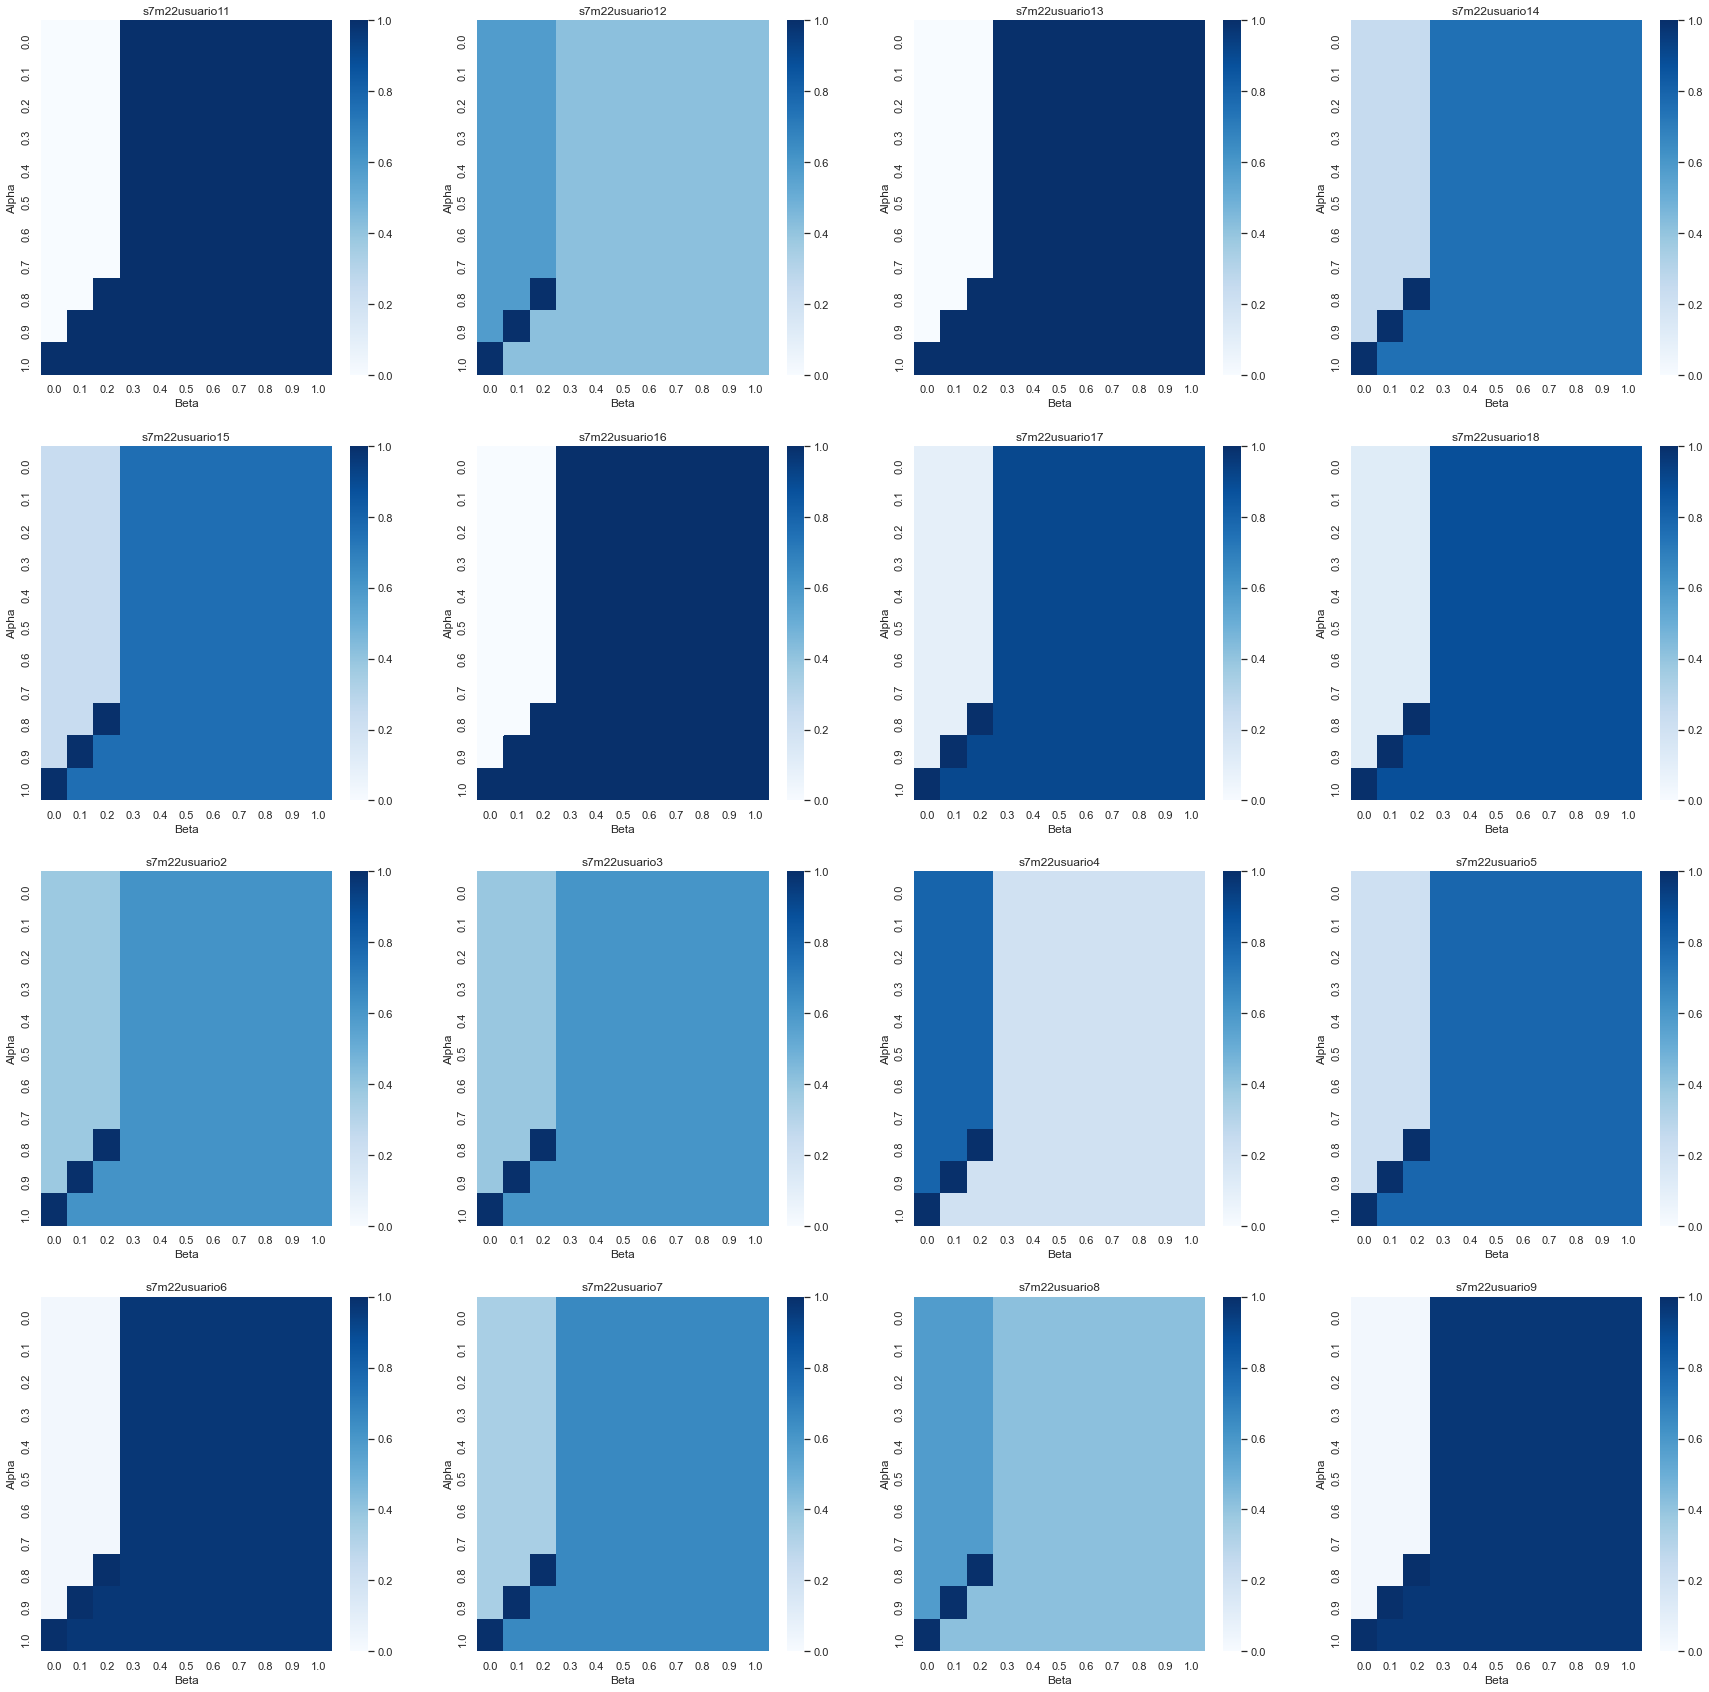

In [38]:
for i in range(number_of_participants//6):
    plt.subplot(no_of_cols, no_of_rows, i+1)
    make_heatmap(i+80)
    
plt.show()

In [39]:
# Making a dummy variable for the particiant type who error is minimised in the left half of the heat map

freq_table['Is_lowtype'] = 1
freq_table.loc['s11n9usuario4',   'Is_lowtype'] = 0
freq_table.loc['s11n9usuario7',   'Is_lowtype'] = 0
freq_table.loc['s12n11usuario1',  'Is_lowtype'] = 0
freq_table.loc['s12n11usuario12', 'Is_lowtype'] = 0
freq_table.loc['s12n11usuario15', 'Is_lowtype'] = 0
freq_table.loc['s12n11usuario17', 'Is_lowtype'] = 0
freq_table.loc['s12n11usuario3',  'Is_lowtype'] = 0
freq_table.loc['s5m20usuario13',  'Is_lowtype'] = 0
freq_table.loc['s5m20usuario17',  'Is_lowtype'] = 0
freq_table.loc['s5m20usuario3',   'Is_lowtype'] = 0
freq_table.loc['s5m20usuario5',   'Is_lowtype'] = 0
freq_table.loc['s5m20usuario7',   'Is_lowtype'] = 0
freq_table.loc['s5m20usuario8',   'Is_lowtype'] = 0
freq_table.loc['s6m22usuario11',  'Is_lowtype'] = 0
freq_table.loc['s6m22usuario4',   'Is_lowtype'] = 0
freq_table.loc['s6m22usuario8',   'Is_lowtype'] = 0
freq_table.loc['s6m22usuario9',   'Is_lowtype'] = 0
freq_table.loc['s7m22usuario1',   'Is_lowtype'] = 0
freq_table.loc['s7m22usuario12',  'Is_lowtype'] = 0
freq_table.loc['s7m22usuario4',   'Is_lowtype'] = 0
freq_table.loc['s7m22usuario8',   'Is_lowtype'] = 0

In [40]:
exp1 = freq_table[freq_table['Is_lowtype']==1].sum()
exp2 = freq_table[freq_table['Is_lowtype']==0].sum()

cont_table = pd.DataFrame(index=['C', 'D'], columns=['LowType', 'HighType'], data=[[exp1[0], exp2[0]], [exp1[3], exp2[3]]])
    
# Chi-square test
chi2, p, dof, expected = chi2_contingency(cont_table)

# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Reject H0: Variables are dependent')
else:
    print('H0 holds true: Variables are independent')

p value is 4.844017581926365e-05
Reject H0: Variables are dependent


In [41]:
reg = pd.DataFrame(index=df.index, columns=['player', 'C_dummy', 'payoff', 'payoff_opponent', 'Is_lowtype', 'D_freq'])
reg['C_dummy'] = pd.get_dummies(df['action_player'])
reg[['player', 'payoff', 'payoff_opponent']] = df[['player', 'payoff', 'payoff_opponent']]


for i in df['player'].unique():
    reg['Is_lowtype'][reg['player']==i] = freq_table.loc[i, 'Is_lowtype']
    reg['D_freq'][reg['player']==i] = freq_table.loc[i, 'D_freq']

In [42]:
# Regress D on Is_lowtype, payoff and payoff_opponent
import statsmodels.formula.api as smf

formula = 'C_dummy ~ payoff + Is_lowtype'
log_reg = smf.logit(formula, data=reg).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.465783
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                C_dummy   No. Observations:                 9600
Model:                          Logit   Df Residuals:                     9597
Method:                           MLE   Df Model:                            2
Date:                Tue, 22 Nov 2022   Pseudo R-squ.:                  0.2208
Time:                        15:38:51   Log-Likelihood:                -4471.5
converged:                       True   LL-Null:                       -5738.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.4667      0.060     24.278      0.000       1.348       1.585
Is_lowtype[T.1]    -2.1926      0.060    -36.789      0.000      -2.309      -2.076
payoff             -0.5929      0.024    -25.064      0.000      -0.639      -0.547
===================================================================================
"""